<a href="https://colab.research.google.com/github/starlingomez/preworkmac/blob/master/6_de_diciembre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#goga bitadze

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 31.6346 - mae: 4.8682 - val_loss: 24.5380 - val_mae: 4.1963 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.7097 - mae: 4.1072 - val_loss: 16.8833 - val_mae: 3.4455 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.6326 - mae: 3.0999 - val_loss: 9.8612 - val_mae: 2.6244 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.3816 - mae: 2.6248 - val_loss: 6.1284 - val_mae: 2.0627 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7976 - mae: 2.4503 - val_loss: 5.5059 - val_mae: 1.9522 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6122 - mae: 2.1562 - val_loss: 5.8853 - val_mae: 2.0327 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8392 - mae: 2.2366 - val_loss: 5.6672 - val_mae: 2.0007 - learning_rate: 0.0010
Epoch 8/100
23/23 

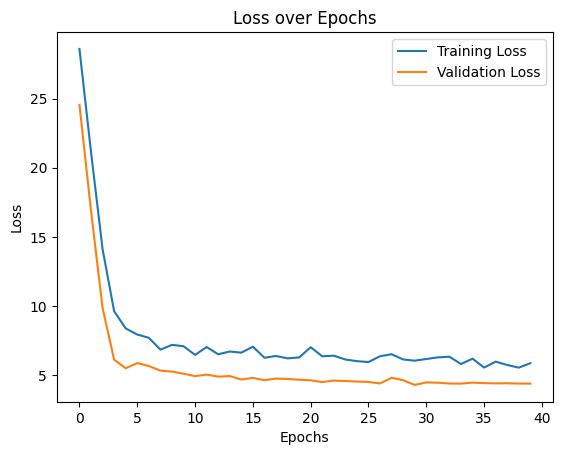

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted total rebounds for the player's next game: 5.10


5.0993586

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_reb_last5 = (avg_min_last5 / 40) * np.random.uniform(3, 15, num_samples)
    opp_avg_reb_allowed = np.random.uniform(40, 60, num_samples)
    player_avg_reb_vs_opp = np.random.uniform(3, 15, num_samples)
    home_indicator = np.random.randint(0, 2, num_samples)
    back_to_back = np.random.randint(0, 2, num_samples)

    # Generate target variable
    rebounds_next_game = (
        0.6 * avg_reb_last5 +
        0.1 * (avg_min_last5 / 48) * 18 +
        0.3 * (player_avg_reb_vs_opp / 48) * 10 +
        np.random.normal(0, 2, num_samples)
    )
    rebounds_next_game = np.clip(rebounds_next_game, 0, 20)

    # Assemble dataset
    data = pd.DataFrame({
        'avg_reb_last5': avg_reb_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_reb_allowed': opp_avg_reb_allowed,
        'player_avg_reb_vs_opp': player_avg_reb_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'rebounds_next_game': rebounds_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('rebounds_next_game', axis=1)
    y = data['rebounds_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict rebounds
    prediction = model.predict(player_processed)
    print(f"Predicted total rebounds for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_reb_last5': [7.6],
    'avg_min_last5': [25],
    'opp_avg_reb_allowed': [44.3],
    'player_avg_reb_vs_opp': [2.3],
    'home_indicator': [0],
    'back_to_back': [0]
})
predict_for_player(model, scaler, player_data)


#frank wagner

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 55.7230 - mae: 6.7752 - val_loss: 49.1733 - val_mae: 6.2734 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.5900 - mae: 5.7610 - val_loss: 35.8554 - val_mae: 5.2620 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.9507 - mae: 4.6865 - val_loss: 20.3155 - val_mae: 3.8806 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3009 - mae: 3.3820 - val_loss: 10.2599 - val_mae: 2.7044 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.3577 - mae: 2.7023 - val_loss: 7.4753 - val_mae: 2.3230 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.7066 - mae: 2.6216 - val_loss: 7.1956 - val_mae: 2.2743 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.7317 - mae: 2.7531 - val_loss: 7.2295 - val_mae: 2.2986 - learning_rate: 0.0010
Epoch 8/100
2

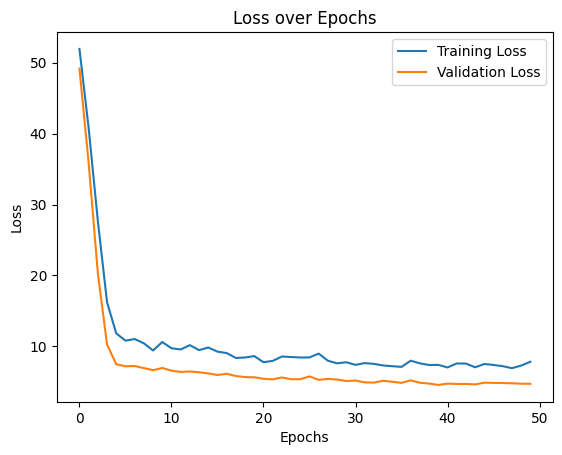

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted total rebounds for the player's next game: 6.21


6.2062955

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_reb_last5 = (avg_min_last5 / 40) * np.random.uniform(3, 15, num_samples)
    opp_avg_reb_allowed = np.random.uniform(40, 60, num_samples)
    player_avg_reb_vs_opp = np.random.uniform(3, 15, num_samples)
    home_indicator = np.random.randint(0, 2, num_samples)
    back_to_back = np.random.randint(0, 2, num_samples)

    # Generate target variable
    rebounds_next_game = (
        0.6 * avg_reb_last5 +
        0.1 * (avg_min_last5 / 48) * 18 +
        0.3 * player_avg_reb_vs_opp +
        np.random.normal(0, 2, num_samples)
    )
    rebounds_next_game = np.clip(rebounds_next_game, 0, 20)

    # Assemble dataset
    data = pd.DataFrame({
        'avg_reb_last5': avg_reb_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_reb_allowed': opp_avg_reb_allowed,
        'player_avg_reb_vs_opp': player_avg_reb_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'rebounds_next_game': rebounds_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('rebounds_next_game', axis=1)
    y = data['rebounds_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict rebounds
    prediction = model.predict(player_processed)
    print(f"Predicted total rebounds for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_reb_last5': [5.7],
    'avg_min_last5': [36.2],
    'opp_avg_reb_allowed': [44.3],
    'player_avg_reb_vs_opp': [6.3],
    'home_indicator': [0],
    'back_to_back': [0]
})
predict_for_player(model, scaler, player_data)


#moriz wagner

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 52.5982 - mae: 6.5167 - val_loss: 44.2139 - val_mae: 5.9073 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 35.0875 - mae: 5.1624 - val_loss: 27.8959 - val_mae: 4.5674 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.2021 - mae: 4.0536 - val_loss: 14.5526 - val_mae: 3.1710 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.9036 - mae: 3.0208 - val_loss: 9.3745 - val_mae: 2.5168 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.3531 - mae: 2.8130 - val_loss: 8.1727 - val_mae: 2.3689 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.3985 - mae: 2.5434 - val_loss: 7.6890 - val_mae: 2.2947 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.3156 - mae: 2.4292 - val_loss: 7.0972 - val_mae: 2.2039 - learning_rate: 0.0010
Epoch 8/100
23/

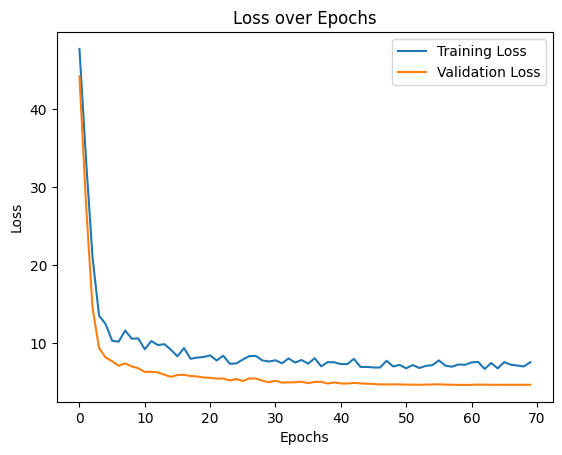

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted total rebounds for the player's next game: 5.42


5.4246616

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_reb_last5 = (avg_min_last5 / 40) * np.random.uniform(3, 15, num_samples)
    opp_avg_reb_allowed = np.random.uniform(40, 60, num_samples)
    player_avg_reb_vs_opp = np.random.uniform(3, 15, num_samples)
    home_indicator = np.random.randint(0, 2, num_samples)
    back_to_back = np.random.randint(0, 2, num_samples)

    # Generate target variable
    rebounds_next_game = (
        0.6 * avg_reb_last5 +
        0.1 * (avg_min_last5 / 48) * 18 +
        0.3 * player_avg_reb_vs_opp +
        np.random.normal(0, 2, num_samples)
    )
    rebounds_next_game = np.clip(rebounds_next_game, 0, 20)

    # Assemble dataset
    data = pd.DataFrame({
        'avg_reb_last5': avg_reb_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_reb_allowed': opp_avg_reb_allowed,
        'player_avg_reb_vs_opp': player_avg_reb_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'rebounds_next_game': rebounds_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('rebounds_next_game', axis=1)
    y = data['rebounds_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict rebounds
    prediction = model.predict(player_processed)
    print(f"Predicted total rebounds for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_reb_last5': [6.2],
    'avg_min_last5': [20.2],
    'opp_avg_reb_allowed': [44.3],
    'player_avg_reb_vs_opp': [3.4],
    'home_indicator': [0],
    'back_to_back': [0]
})
predict_for_player(model, scaler, player_data)


#yabusele

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 52.6064 - mae: 6.5158 - val_loss: 44.9762 - val_mae: 5.9758 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 39.0714 - mae: 5.4272 - val_loss: 30.4866 - val_mae: 4.8039 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.3999 - mae: 4.0968 - val_loss: 16.0216 - val_mae: 3.4258 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2814 - mae: 3.3117 - val_loss: 8.6699 - val_mae: 2.4499 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.7436 - mae: 2.7608 - val_loss: 7.7171 - val_mae: 2.3084 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.6392 - mae: 2.6483 - val_loss: 7.2074 - val_mae: 2.2189 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.4776 - mae: 2.5713 - val_loss: 7.0136 - val_mae: 2.1923 - learning_rate: 0.0010
Ep

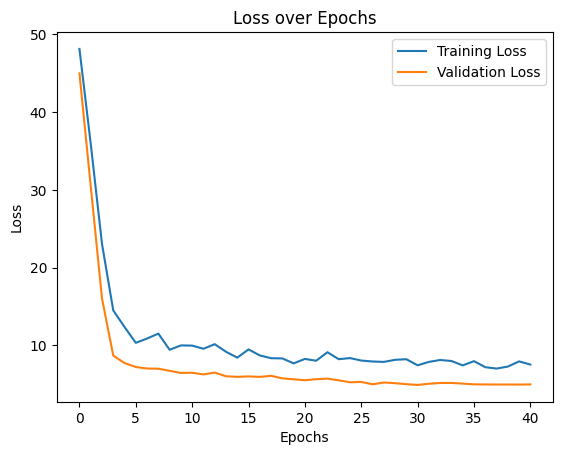

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted total rebounds for the player's next game: 4.92


4.9245734

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_reb_last5 = (avg_min_last5 / 40) * np.random.uniform(3, 15, num_samples)
    opp_avg_reb_allowed = np.random.uniform(40, 60, num_samples)
    player_avg_reb_vs_opp = np.random.uniform(3, 15, num_samples)
    home_indicator = np.random.randint(0, 2, num_samples)
    back_to_back = np.random.randint(0, 2, num_samples)

    # Generate target variable
    rebounds_next_game = (
        0.6 * avg_reb_last5 +
        0.1 * (avg_min_last5 / 48) * 18 +
        0.3 * player_avg_reb_vs_opp +
        np.random.normal(0, 2, num_samples)
    )
    rebounds_next_game = np.clip(rebounds_next_game, 0, 20)

    # Assemble dataset
    data = pd.DataFrame({
        'avg_reb_last5': avg_reb_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_reb_allowed': opp_avg_reb_allowed,
        'player_avg_reb_vs_opp': player_avg_reb_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'rebounds_next_game': rebounds_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('rebounds_next_game', axis=1)
    y = data['rebounds_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict rebounds
    prediction = model.predict(player_processed)
    print(f"Predicted total rebounds for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_reb_last5': [7],
    'avg_min_last5': [28],
    'opp_avg_reb_allowed': [48.5],
    'player_avg_reb_vs_opp': [4.5],
    'home_indicator': [1],
    'back_to_back': [0]
})
predict_for_player(model, scaler, player_data)


#jason tatum

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 55.7468 - mae: 6.8369 - val_loss: 47.0550 - val_mae: 6.2869 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.7029 - mae: 5.8349 - val_loss: 31.2052 - val_mae: 4.9734 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.7911 - mae: 4.2297 - val_loss: 15.5554 - val_mae: 3.3187 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.6644 - mae: 3.1812 - val_loss: 7.4306 - val_mae: 2.1414 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.0033 - mae: 2.6666 - val_loss: 6.1867 - val_mae: 1.9210 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.6576 - mae: 2.7514 - val_loss: 6.0874 - val_mae: 1.9281 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9617 - mae: 2.4949 - val_loss: 5.9106 - val_mae: 1.9164 - learning_rate: 0.0010
Epoch 8/100
23/

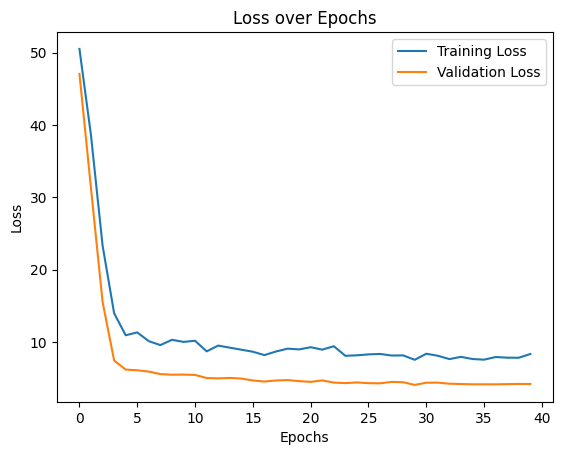

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted total rebounds for the player's next game: 10.17


10.170989

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_reb_last5 = (avg_min_last5 / 40) * np.random.uniform(3, 15, num_samples)
    opp_avg_reb_allowed = np.random.uniform(40, 60, num_samples)
    player_avg_reb_vs_opp = np.random.uniform(3, 15, num_samples)
    home_indicator = np.random.randint(0, 1, num_samples)
    back_to_back = np.random.randint(0, 1, num_samples)

    # Generate target variable
    rebounds_next_game = (
        0.6 * avg_reb_last5 +
        0.1 * (avg_min_last5 / 48) * 18 +
        0.3 * player_avg_reb_vs_opp +
        np.random.normal(0, 2, num_samples)
    )
    rebounds_next_game = np.clip(rebounds_next_game, 0, 20)

    # Assemble dataset
    data = pd.DataFrame({
        'avg_reb_last5': avg_reb_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_reb_allowed': opp_avg_reb_allowed,
        'player_avg_reb_vs_opp': player_avg_reb_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'rebounds_next_game': rebounds_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('rebounds_next_game', axis=1)
    y = data['rebounds_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict rebounds
    prediction = model.predict(player_processed)
    print(f"Predicted total rebounds for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_reb_last5': [10.1],
    'avg_min_last5': [36.7],
    'opp_avg_reb_allowed': [42.7],
    'player_avg_reb_vs_opp': [10],
    'home_indicator': [0],
    'back_to_back': [0]
})
predict_for_player(model, scaler, player_data)


#jaylan brown

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 51.9516 - mae: 6.5424 - val_loss: 49.1605 - val_mae: 6.4402 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 44.7577 - mae: 5.9671 - val_loss: 35.7085 - val_mae: 5.3765 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 33.4077 - mae: 5.0411 - val_loss: 20.5770 - val_mae: 3.8517 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.3517 - mae: 3.5041 - val_loss: 10.5727 - val_mae: 2.6097 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13.8304 - mae: 2.9473 - val_loss: 7.3592 - val_mae: 2.1283 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.5090 - mae: 2.7197 - val_loss: 6.4552 - val_mae: 1.9760 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.1966 - mae: 2.6752 - val_loss: 6.0151 - val_mae: 1.9072 - learning_rate: 0.0010

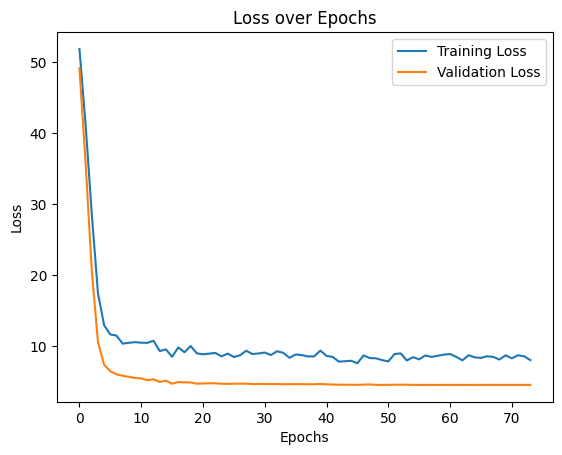

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted total rebounds for the player's next game: 6.83


6.8256545

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_reb_last5 = (avg_min_last5 / 40) * np.random.uniform(3, 15, num_samples)
    opp_avg_reb_allowed = np.random.uniform(40, 60, num_samples)
    player_avg_reb_vs_opp = np.random.uniform(3, 15, num_samples)
    home_indicator = np.random.randint(0, 1, num_samples)
    back_to_back = np.random.randint(0, 1, num_samples)

    # Generate target variable
    rebounds_next_game = (
        0.6 * avg_reb_last5 +
        0.1 * (avg_min_last5 / 48) * 18 +
        0.3 * player_avg_reb_vs_opp +
        np.random.normal(0, 2, num_samples)
    )
    rebounds_next_game = np.clip(rebounds_next_game, 0, 20)

    # Assemble dataset
    data = pd.DataFrame({
        'avg_reb_last5': avg_reb_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_reb_allowed': opp_avg_reb_allowed,
        'player_avg_reb_vs_opp': player_avg_reb_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'rebounds_next_game': rebounds_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('rebounds_next_game', axis=1)
    y = data['rebounds_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict rebounds
    prediction = model.predict(player_processed)
    print(f"Predicted total rebounds for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_reb_last5': [6.1],
    'avg_min_last5': [36.4],
    'opp_avg_reb_allowed': [42.7],
    'player_avg_reb_vs_opp': [5.7],
    'home_indicator': [0],
    'back_to_back': [1]
})
predict_for_player(model, scaler, player_data)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 65.6140 - mae: 7.5923 - val_loss: 58.5887 - val_mae: 7.0650 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.1783 - mae: 6.4881 - val_loss: 42.7586 - val_mae: 5.8901 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36.7649 - mae: 5.2859 - val_loss: 25.3076 - val_mae: 4.3544 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.8266 - mae: 3.7981 - val_loss: 13.8940 - val_mae: 3.0845 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.4441 - mae: 3.2269 - val_loss: 9.9390 - val_mae: 2.6214 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.7406 - mae: 3.0396 - val_loss: 9.0618 - val_mae: 2.5308 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.5802 - mae: 2.9035 - val_loss: 8.3126 - val_mae: 2.4261 - learning_rate: 0.0010
E

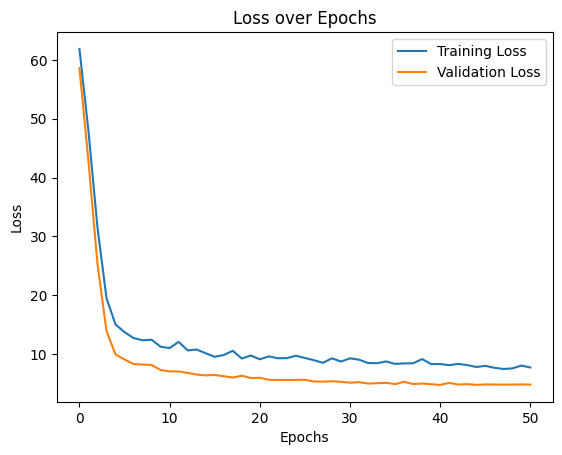

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted total rebounds for the player's next game: 6.70


6.704639

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_reb_last5 = (avg_min_last5 / 40) * np.random.uniform(3, 15, num_samples)
    opp_avg_reb_allowed = np.random.uniform(40, 60, num_samples)
    player_avg_reb_vs_opp = np.random.uniform(3, 15, num_samples)
    home_indicator = np.random.randint(0, 2, num_samples)
    back_to_back = np.random.randint(0, 2, num_samples)

    # Generate target variable
    rebounds_next_game = (
        0.4 * avg_reb_last5 +
        0.1 * (avg_min_last5 / 48) * 18 +
        0.3 * player_avg_reb_vs_opp +
        0.2 * (opp_avg_reb_allowed / 50) * 10 +
        np.random.normal(0, 2, num_samples)
    )
    rebounds_next_game = np.clip(rebounds_next_game, 0, 20)

    # Assemble dataset
    data = pd.DataFrame({
        'avg_reb_last5': avg_reb_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_reb_allowed': opp_avg_reb_allowed,
        'player_avg_reb_vs_opp': player_avg_reb_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'rebounds_next_game': rebounds_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('rebounds_next_game', axis=1)
    y = data['rebounds_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict rebounds
    prediction = model.predict(player_processed)
    print(f"Predicted total rebounds for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_reb_last5': [6.1],
    'avg_min_last5': [36.4],
    'opp_avg_reb_allowed': [45.7],
    'player_avg_reb_vs_opp': [5.7],
    'home_indicator': [0],
    'back_to_back': [1]
})
predict_for_player(model, scaler, player_data)


#clint capela

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 49.2154 - mae: 6.3313 - val_loss: 42.2603 - val_mae: 5.7991 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 34.4049 - mae: 5.1633 - val_loss: 26.4026 - val_mae: 4.4718 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 20.7476 - mae: 3.8302 - val_loss: 12.0395 - val_mae: 2.9432 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.2275 - mae: 2.9778 - val_loss: 7.6524 - val_mae: 2.3160 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7993 - mae: 2.5090 - val_loss: 7.1676 - val_mae: 2.2725 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.2653 - mae: 2.5271 - val_loss: 6.9404 - val_mae: 2.2440 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.7719 - mae: 2.5650 - val_loss: 7.0098 - val_mae: 2.2633 - learning_rate: 0.0010
Ep

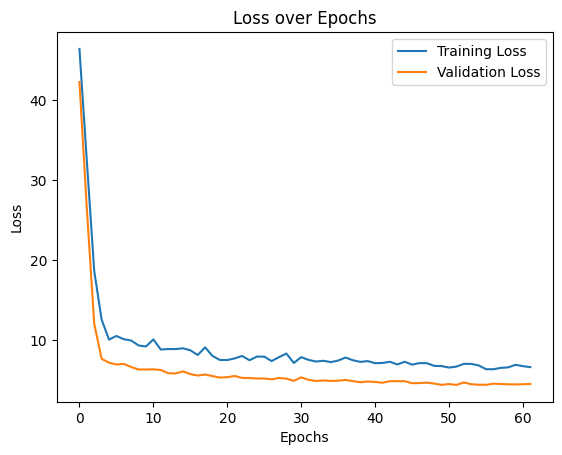

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted total rebounds for the player's next game: 10.96


10.95685

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_reb_last5 = (avg_min_last5 / 40) * np.random.uniform(3, 15, num_samples)
    opp_avg_reb_allowed = np.random.uniform(40, 60, num_samples)
    player_avg_reb_vs_opp = np.random.uniform(3, 15, num_samples)
    home_indicator = np.random.randint(0, 2, num_samples)
    back_to_back = np.random.randint(0, 2, num_samples)

    # Generate target variable
    rebounds_next_game = (
        0.6 * avg_reb_last5 +
        0.1 * (avg_min_last5 / 48) * 18 +
        0.3 * player_avg_reb_vs_opp +
        np.random.normal(0, 2, num_samples)
    )
    rebounds_next_game = np.clip(rebounds_next_game, 0, 20)

    # Assemble dataset
    data = pd.DataFrame({
        'avg_reb_last5': avg_reb_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_reb_allowed': opp_avg_reb_allowed,
        'player_avg_reb_vs_opp': player_avg_reb_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'rebounds_next_game': rebounds_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('rebounds_next_game', axis=1)
    y = data['rebounds_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict rebounds
    prediction = model.predict(player_processed)
    print(f"Predicted total rebounds for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_reb_last5': [11.8],
    'avg_min_last5': [23.6],
    'opp_avg_reb_allowed': [42.2],
    'player_avg_reb_vs_opp': [9.9],
    'home_indicator': [1],
    'back_to_back': [0]
})
predict_for_player(model, scaler, player_data)


#jalen johnson

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 48.7227 - mae: 6.3165 - val_loss: 42.3278 - val_mae: 5.7937 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.6481 - mae: 5.2018 - val_loss: 27.7017 - val_mae: 4.5638 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.6320 - mae: 3.8662 - val_loss: 14.3711 - val_mae: 3.1863 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.1965 - mae: 3.1216 - val_loss: 8.6719 - val_mae: 2.4745 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.7770 - mae: 2.5813 - val_loss: 7.6314 - val_mae: 2.3212 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.8244 - mae: 2.7562 - val_loss: 7.3961 - val_mae: 2.2702 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.1088 - mae: 2.6620 - val_loss: 7.2886 - val_mae: 2.2678 - learning_rate: 0.0010
Epoch 8/100
23

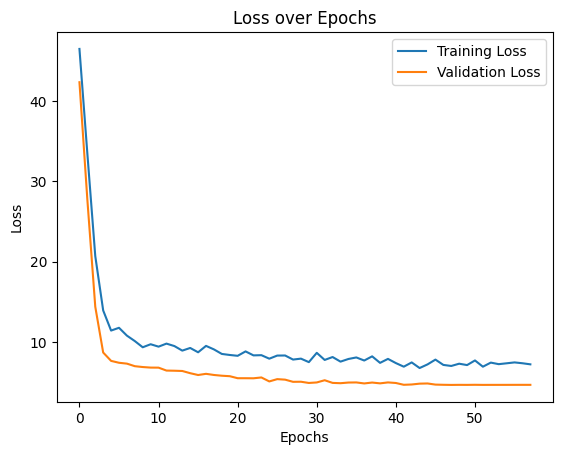

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted total rebounds for the player's next game: 8.89


8.89147

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_reb_last5 = (avg_min_last5 / 40) * np.random.uniform(3, 15, num_samples)
    opp_avg_reb_allowed = np.random.uniform(40, 60, num_samples)
    player_avg_reb_vs_opp = np.random.uniform(3, 15, num_samples)
    home_indicator = np.random.randint(0, 2, num_samples)
    back_to_back = np.random.randint(0, 2, num_samples)

    # Generate target variable
    rebounds_next_game = (
        0.6 * avg_reb_last5 +
        0.1 * (avg_min_last5 / 48) * 18 +
        0.3 * player_avg_reb_vs_opp +
        np.random.normal(0, 2, num_samples)
    )
    rebounds_next_game = np.clip(rebounds_next_game, 0, 20)

    # Assemble dataset
    data = pd.DataFrame({
        'avg_reb_last5': avg_reb_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_reb_allowed': opp_avg_reb_allowed,
        'player_avg_reb_vs_opp': player_avg_reb_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'rebounds_next_game': rebounds_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('rebounds_next_game', axis=1)
    y = data['rebounds_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict rebounds
    prediction = model.predict(player_processed)
    print(f"Predicted total rebounds for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_reb_last5': [9.2],
    'avg_min_last5': [36.2],
    'opp_avg_reb_allowed': [42.2],
    'player_avg_reb_vs_opp': [10],
    'home_indicator': [1],
    'back_to_back': [0]
})
predict_for_player(model, scaler, player_data)


#keegan murray

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 48.4955 - mae: 6.2808 - val_loss: 44.4457 - val_mae: 5.9294 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 38.6476 - mae: 5.4271 - val_loss: 30.3616 - val_mae: 4.7956 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 24.7850 - mae: 4.2353 - val_loss: 16.9693 - val_mae: 3.5052 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.3534 - mae: 3.0910 - val_loss: 10.6081 - val_mae: 2.6872 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.8200 - mae: 2.8857 - val_loss: 8.4838 - val_mae: 2.4382 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.5489 - mae: 2.9701 - val_loss: 8.0724 - val_mae: 2.3856 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.5515 - mae: 2.7467 - val_loss: 7.8283 - val_mae: 2.3527 - learning_rate: 0.0010
Epoch 8/100


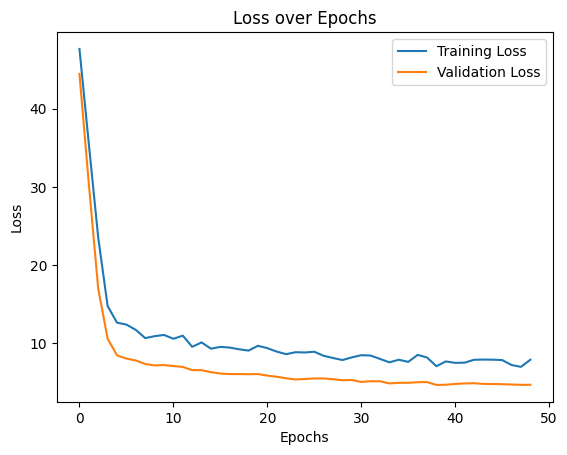

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted total rebounds for the player's next game: 7.63


7.6282487

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_reb_last5 = (avg_min_last5 / 40) * np.random.uniform(3, 15, num_samples)
    opp_avg_reb_allowed = np.random.uniform(40, 60, num_samples)
    player_avg_reb_vs_opp = np.random.uniform(3, 15, num_samples)
    home_indicator = np.random.randint(0, 2, num_samples)
    back_to_back = np.random.randint(0, 2, num_samples)

    # Generate target variable
    rebounds_next_game = (
        0.6 * avg_reb_last5 +
        0.1 * (avg_min_last5 / 48) * 18 +
        0.3 * player_avg_reb_vs_opp +
        np.random.normal(0, 2, num_samples)
    )
    rebounds_next_game = np.clip(rebounds_next_game, 0, 20)

    # Assemble dataset
    data = pd.DataFrame({
        'avg_reb_last5': avg_reb_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_reb_allowed': opp_avg_reb_allowed,
        'player_avg_reb_vs_opp': player_avg_reb_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'rebounds_next_game': rebounds_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('rebounds_next_game', axis=1)
    y = data['rebounds_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict rebounds
    prediction = model.predict(player_processed)
    print(f"Predicted total rebounds for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_reb_last5': [7.4],
    'avg_min_last5': [36.3],
    'opp_avg_reb_allowed': [41.8],
    'player_avg_reb_vs_opp': [4.8],
    'home_indicator': [0],
    'back_to_back': [0]
})
predict_for_player(model, scaler, player_data)


#paul siakam

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 53.3339 - mae: 6.6574 - val_loss: 45.4911 - val_mae: 6.0650 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.8010 - mae: 5.4701 - val_loss: 30.6579 - val_mae: 4.8777 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.9874 - mae: 4.3900 - val_loss: 16.7661 - val_mae: 3.4656 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.6247 - mae: 3.2678 - val_loss: 9.3985 - val_mae: 2.5103 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.9817 - mae: 2.8149 - val_loss: 7.6386 - val_mae: 2.2845 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.3558 - mae: 3.0148 - val_loss: 7.6618 - val_mae: 2.3076 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.8273 - mae: 2.5906 - val_loss: 7.3825 - val_mae: 2.2783 - learning_rate: 0.0010
Epoch 8/100
23

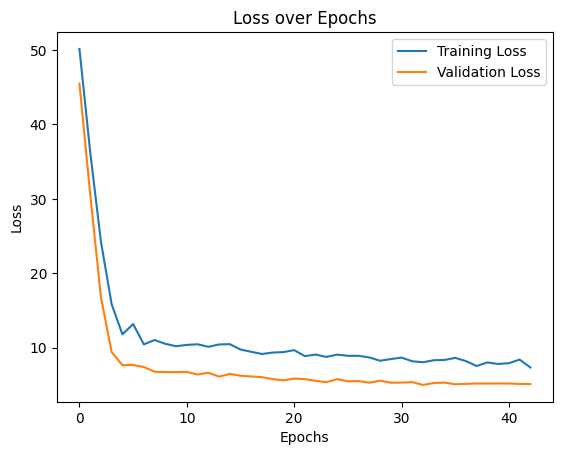

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted total rebounds for the player's next game: 7.09


7.0884285

In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_reb_last5 = (avg_min_last5 / 40) * np.random.uniform(3, 15, num_samples)
    opp_avg_reb_allowed = np.random.uniform(40, 60, num_samples)
    player_avg_reb_vs_opp = np.random.uniform(3, 15, num_samples)
    home_indicator = np.random.randint(0, 2, num_samples)
    back_to_back = np.random.randint(0, 2, num_samples)

    # Generate target variable
    rebounds_next_game = (
        0.6 * avg_reb_last5 +
        0.1 * (avg_min_last5 / 48) * 18 +
        0.3 * player_avg_reb_vs_opp +
        np.random.normal(0, 2, num_samples)
    )
    rebounds_next_game = np.clip(rebounds_next_game, 0, 20)

    # Assemble dataset
    data = pd.DataFrame({
        'avg_reb_last5': avg_reb_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_reb_allowed': opp_avg_reb_allowed,
        'player_avg_reb_vs_opp': player_avg_reb_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'rebounds_next_game': rebounds_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('rebounds_next_game', axis=1)
    y = data['rebounds_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict rebounds
    prediction = model.predict(player_processed)
    print(f"Predicted total rebounds for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_reb_last5': [6.5],
    'avg_min_last5': [36.3],
    'opp_avg_reb_allowed': [41.8],
    'player_avg_reb_vs_opp': [7],
    'home_indicator': [1],
    'back_to_back': [0]
})
predict_for_player(model, scaler, player_data)


#anthony edward

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 56.5791 - mae: 6.8573 - val_loss: 49.9052 - val_mae: 6.3719 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 43.2992 - mae: 5.8364 - val_loss: 35.3605 - val_mae: 5.2318 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30.6825 - mae: 4.7761 - val_loss: 19.8106 - val_mae: 3.8212 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.9140 - mae: 3.5390 - val_loss: 10.6352 - val_mae: 2.6786 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.5333 - mae: 2.9325 - val_loss: 8.0148 - val_mae: 2.3302 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.2738 - mae: 2.6921 - val_loss: 7.5047 - val_mae: 2.2677 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.8481 - mae: 2.6032 - val_loss: 7.5216 - val_mae: 2.2741 - learning_rate: 0.0010
Epoch 8/100


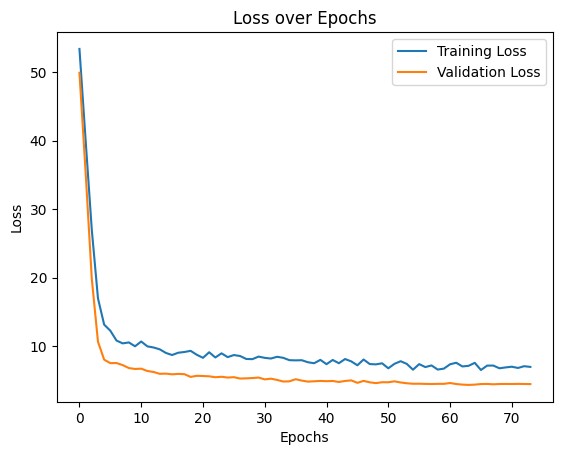

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted total rebounds for the player's next game: 6.17


6.1701555

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_reb_last5 = (avg_min_last5 / 40) * np.random.uniform(3, 15, num_samples)
    opp_avg_reb_allowed = np.random.uniform(40, 60, num_samples)
    player_avg_reb_vs_opp = np.random.uniform(3, 15, num_samples)
    home_indicator = np.random.randint(0, 2, num_samples)
    back_to_back = np.random.randint(0, 2, num_samples)

    # Generate target variable
    rebounds_next_game = (
        0.6 * avg_reb_last5 +
        0.1 * (avg_min_last5 / 48) * 18 +
        0.3 * player_avg_reb_vs_opp +
        np.random.normal(0, 2, num_samples)
    )
    rebounds_next_game = np.clip(rebounds_next_game, 0, 20)

    # Assemble dataset
    data = pd.DataFrame({
        'avg_reb_last5': avg_reb_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_reb_allowed': opp_avg_reb_allowed,
        'player_avg_reb_vs_opp': player_avg_reb_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'rebounds_next_game': rebounds_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('rebounds_next_game', axis=1)
    y = data['rebounds_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict rebounds
    prediction = model.predict(player_processed)
    print(f"Predicted total rebounds for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_reb_last5': [5.7],
    'avg_min_last5': [36.6],
    'opp_avg_reb_allowed': [41.3],
    'player_avg_reb_vs_opp': [4.5],
    'home_indicator': [1],
    'back_to_back': [0]
})
predict_for_player(model, scaler, player_data)


#john collin

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 51.1330 - mae: 6.5355 - val_loss: 47.9103 - val_mae: 6.2309 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 41.6841 - mae: 5.7536 - val_loss: 34.5099 - val_mae: 5.1758 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 28.1997 - mae: 4.5732 - val_loss: 19.1314 - val_mae: 3.7650 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.8674 - mae: 3.3200 - val_loss: 9.6130 - val_mae: 2.6253 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.5531 - mae: 2.7465 - val_loss: 7.4613 - val_mae: 2.3178 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.4277 - mae: 2.7166 - val_loss: 7.0196 - val_mae: 2.2681 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.4159 - mae: 2.5595 - val_loss: 7.0663 - val_mae: 2.2826 - learning_rate: 0.0010
Ep

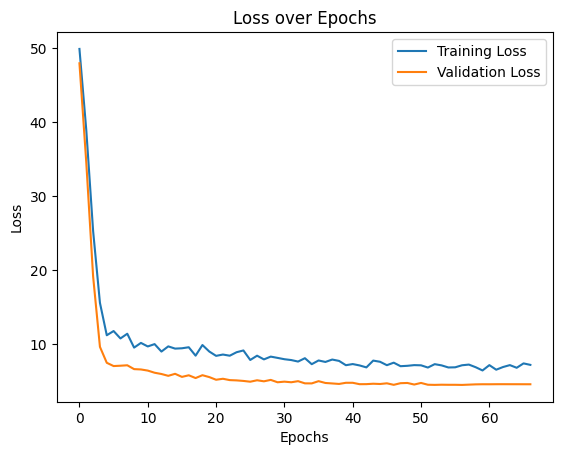

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted total rebounds for the player's next game: 9.07


9.068673

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_reb_last5 = (avg_min_last5 / 40) * np.random.uniform(3, 15, num_samples)
    opp_avg_reb_allowed = np.random.uniform(40, 60, num_samples)
    player_avg_reb_vs_opp = np.random.uniform(3, 15, num_samples)
    home_indicator = np.random.randint(0, 2, num_samples)
    back_to_back = np.random.randint(0, 2, num_samples)

    # Generate target variable
    rebounds_next_game = (
        0.6 * avg_reb_last5 +
        0.1 * (avg_min_last5 / 48) * 18 +
        0.3 * player_avg_reb_vs_opp +
        np.random.normal(0, 2, num_samples)
    )
    rebounds_next_game = np.clip(rebounds_next_game, 0, 20)

    # Assemble dataset
    data = pd.DataFrame({
        'avg_reb_last5': avg_reb_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_reb_allowed': opp_avg_reb_allowed,
        'player_avg_reb_vs_opp': player_avg_reb_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'rebounds_next_game': rebounds_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('rebounds_next_game', axis=1)
    y = data['rebounds_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict rebounds
    prediction = model.predict(player_processed)
    print(f"Predicted total rebounds for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_reb_last5': [9.7],
    'avg_min_last5': [32.7],
    'opp_avg_reb_allowed': [43.6],
    'player_avg_reb_vs_opp': [10],
    'home_indicator': [1],
    'back_to_back': [0]
})
predict_for_player(model, scaler, player_data)


#rudy gobert

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 53.2179 - mae: 6.6412 - val_loss: 48.2709 - val_mae: 6.2496 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44.1987 - mae: 5.8837 - val_loss: 35.4151 - val_mae: 5.2380 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.6846 - mae: 4.7312 - val_loss: 21.1788 - val_mae: 3.9619 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.4146 - mae: 3.4770 - val_loss: 11.4578 - val_mae: 2.8265 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.4786 - mae: 2.8670 - val_loss: 8.2625 - val_mae: 2.4071 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.7953 - mae: 2.5686 - val_loss: 7.5897 - val_mae: 2.3023 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.3097 - mae: 2.7248 - val_loss: 7.4774 - val_mae: 2.2976 - learning_rate: 0.0010
Epoch 8/100
2

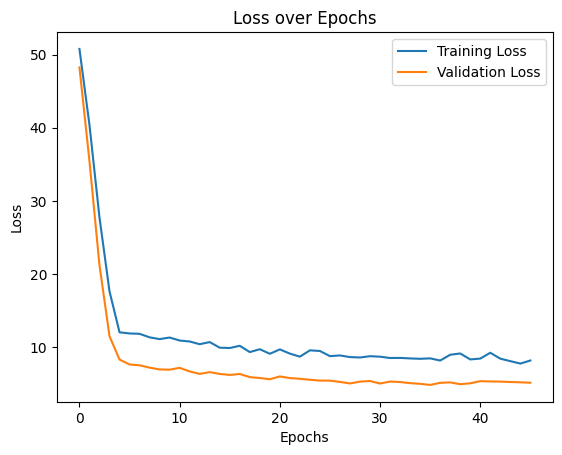

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted total rebounds for the player's next game: 11.47


11.470765

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_synthetic_data(num_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    # Generate features with some correlations
    avg_min_last5 = np.random.uniform(10, 40, num_samples)
    avg_reb_last5 = (avg_min_last5 / 40) * np.random.uniform(3, 15, num_samples)
    opp_avg_reb_allowed = np.random.uniform(40, 60, num_samples)
    player_avg_reb_vs_opp = np.random.uniform(3, 15, num_samples)
    home_indicator = np.random.randint(0, 2, num_samples)
    back_to_back = np.random.randint(0, 2, num_samples)

    # Generate target variable
    rebounds_next_game = (
        0.6 * avg_reb_last5 +
        0.1 * (avg_min_last5 / 48) * 18 +
        0.3 * player_avg_reb_vs_opp +
        np.random.normal(0, 2, num_samples)
    )
    rebounds_next_game = np.clip(rebounds_next_game, 0, 20)

    # Assemble dataset
    data = pd.DataFrame({
        'avg_reb_last5': avg_reb_last5,
        'avg_min_last5': avg_min_last5,
        'opp_avg_reb_allowed': opp_avg_reb_allowed,
        'player_avg_reb_vs_opp': player_avg_reb_vs_opp,
        'home_indicator': home_indicator,
        'back_to_back': back_to_back,
        'rebounds_next_game': rebounds_next_game
    })
    return data

# Function to preprocess data
def preprocess_data(data):
    X = data.drop('rebounds_next_game', axis=1)
    y = data['rebounds_next_game']

    # Separate numerical and categorical features
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])

    # Combine scaled numerical features with categorical features
    X_train_processed = np.hstack((X_train_num_scaled, X_train[categorical_features].values))
    X_test_processed = np.hstack((X_test_num_scaled, X_test[categorical_features].values))

    return X_train_processed, X_test_processed, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R² Score: {r2:.2f}")

    # Visualize results
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions})
    print(results.head(10))
    return results

# Function to predict for a specific player
def predict_for_player(model, scaler, player_data):
    numerical_features = ['avg_reb_last5', 'avg_min_last5', 'opp_avg_reb_allowed', 'player_avg_reb_vs_opp']
    categorical_features = ['home_indicator', 'back_to_back']

    # Scale numerical features
    player_num_scaled = scaler.transform(player_data[numerical_features])

    # Combine scaled numerical features with categorical features
    player_processed = np.hstack((player_num_scaled, player_data[categorical_features].values))

    # Predict rebounds
    prediction = model.predict(player_processed)
    print(f"Predicted total rebounds for the player's next game: {prediction[0][0]:.2f}")
    return prediction[0][0]

# Main code execution
data = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
model = build_model(X_train.shape[1])

# Add early stopping and learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluate_model(model, X_test, y_test)

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predict for a specific player
player_data = pd.DataFrame({
    'avg_reb_last5': [11.8],
    'avg_min_last5': [36.7],
    'opp_avg_reb_allowed': [41.3],
    'player_avg_reb_vs_opp': [11.9],
    'home_indicator': [1],
    'back_to_back': [0]
})
predict_for_player(model, scaler, player_data)
